# GradNorm y Autoencoders Autosupervisados para Hashing Supervisado

## GradNorm

### Definiciones Preliminares
* $W$: subconjunto de pesos del la red completa. Generalmente se eligen los pesos de la ultima capa compartida entre las tareas.
* $G_W^{(i)}(t)$ = $||\nabla_W w_i(t)L_i(t)||_2$, norma $L_2$ del gradiente de la loss ponderada por el peso de la tarea.
* $\overline{G}_W(t) = E_{tasks}[G_W^{(i)}(t)]$: norma promedio de los gradientes sobre todas las tareas. 
Tasa de entrenamiento para la tarea $i$
* $\tilde{L}_i(t) = L_i(t)/L_i(0)$: loss ratio de la tarea $i$ en el tiempo $t$.
* $r_i(t) = \tilde{L}_i(t)/E_{tasks}[\tilde{L}_i(t)]$ tasa de entranamiento inversa relativa de la tarea $i$.

### Algoritmo
GradNorm trata de establecer una escala común para las magnitudes de los gradientes y también debe equilibrar las tasas de entrenamiento para las diferentes tareas. La escala común para los gradientes es la norma del gradiente promedio $\overline{G}_W(t)$, que establece una línea base en cada paso  de entrenamiento $t$ mediante el cual se puede determinar los tamaños gradientes relativos. Ahora, para equilibrar la tasa de los gradientes, se utiliza la tasa de entrenamiento inversa relacionada a la tarea $i$, $r_i(t)$. Cuanto más grande sea $r_i(t)$, mayores deberian ser las magnitudes de los gradientes para la tarea $i$ con el fin de fomentar que la tarea se entrene más rápido. Teniendo todo esto en cuenta, la norma deseada del gradiente para cada tarea $i$ es: $$G_W^{(i)} \longrightarrow \overline{G}_W(t) \times [r_i(t)]^\alpha$$

Donde $\alpha$ es un hiperparámetro adicional, que establece la resistencia de la fuerza restauradora que hace retroceder las tareas a un ritmo de entrenamiento común. En casos donde las tareas son muy diferentes en complejidad, debe utilizarse un valor más alto de $\alpha$, para imponer un equilibrio en la tasa de entrenamiento más fuerte. Cuando las tareas son más simetricas  debe utilizarse un valor de $\alpha$ más cercano a $0$.

Entonces la loss de GradNomrm para poder aprender los pesos, queda dada por: $$L_{grad}(t, w_i(t)) = \sum_i \biggr\lvert G_W^{(i)}(t) - \overline{G}_W(t) \times [r_i(t)]^\alpha \biggr\rvert_1$$


### Toy Example
Funciones a aprender para las $T$ tareas, con $ 1< i < T$:
 
\begin{equation}
f_i(x) = \sigma_i  \tanh((B+\epsilon_i)x) 
\end{equation}

* $B$: matriz constante generada con una distribución normal $N(0, 10)$, de tamaño $100 \times 250$. Las tareas comparten información a partir de esta matriz.
* $\epsilon_i$: matriz constante de dimensión ($100 \times 250$), con una distribución normal $N(0, 3.5)$.
* $\sigma_i$: son escalares fijos que establecen las escalas de las salidas $f_i$. Una escala más alta para $f_i$ induce un valor esperado más alto de pérdida al cuadrado para esa tarea. Estas tareas son más difíciles de aprender debido a las variaciones más altas en sus valores de respuesta, pero también propagan gradientes más grandes. Este escenario generalmente conduce a una dinámica de entrenamiento subóptima cuando las tareas s_i superiores dominan el entrenamiento en todas las tareas.

In [1]:
# Implementation use Tensorflow 2
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
import random
import numpy as np
from keras import backend as K
import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  2
True


Using TensorFlow backend.


In [2]:
from src.toyExample import createData, toyExample
# Set seed for create synthetic data
seed = 40
random.seed(seed)
Tasks = 2

B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons = np.random.normal(scale=3.5, size=(Tasks, 100, 250)).astype(np.float32)
sigmas = [1.0, 100.0]

X, Y = createData(B, epsilons, sigmas, T = Tasks)
print('X shape: ', X.shape)
print('Y shape', Y.shape)
model = toyExample()
model.summary()

X shape:  (10000, 250)
Y shape (10000, 2, 100)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          25100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
_______________________________________________

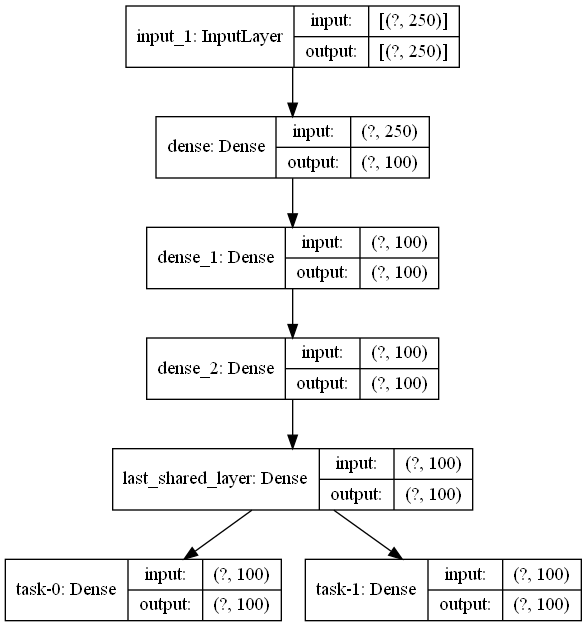

In [3]:
plot_model(model, show_shapes=True)

### Train toy example dont balancing weights

In [4]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model_classic = toyExample()
model_classic.compile(loss='mse', 
                    loss_weights=[1.0, 1.0], #weights of tasks 1.0 , 1.0 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
h = model_classic.fit(X, [Y[:, 0, :], Y[:, 1, :]],
                            # validation_split = 0.2,
                            epochs=50,
                            batch_size=128,
                            verbose=False,
                            callbacks=[history])
history

In [9]:
history.losses[0]

9919.623

2
0
1


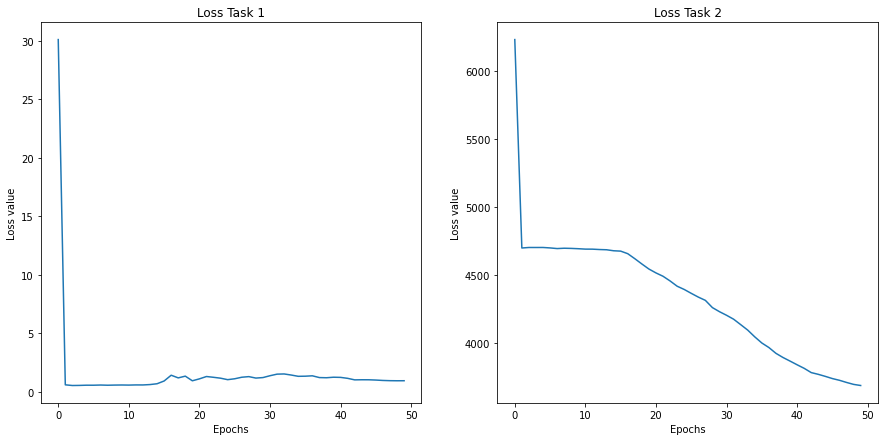

In [10]:
import matplotlib.pyplot as plt

def plotArange(rows, columns, data, xlabels, ylabels, titles, figsize=(15, 7)):
    fig, axs = plt.subplots(nrows=rows, ncols=columns,
                            figsize=figsize,
                            constrained_layout=False)
    print(len(axs))
    count = 0
    # for ax in axs:
    #     print(count)
    #     ax.plot(data[count])
    #     ax.set_xlabel(xlabels)
    #     ax.set_ylabel(ylabels)
    #     ax.set_title(titles[count])
    #     count += 1
    print(axs)
    for row in range(rows):
        for col in range(columns):
            print(count)
            axs[count].plot(data[count])
            axs[count].set_xlabel(xlabels)
            axs[count].set_ylabel(ylabels)
            axs[count].set_title(titles[count])
            count += 1
    return fig

def multiplePlot(data, xlabels, ylabels, legends, figsize=(15, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(data)
    i = 0
    for d in data:
        ax.plot(d, label=legends[i])
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels)
        ax.legend()
        i+=1
    return fig
        


losses = [h.history['task-0_loss'], h.history['task-1_loss']]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels = 'Loss value'
fig = plotArange(1, 2, losses, xlabels, ylabels, titles)

## GradNorm Implementation

### Toy Example With 2 Tasks

In [20]:
from src.gradNorm import GradNorm
losses = [tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean(),
           tf.keras.metrics.Mean()]
weights = [1.0, 1.0]
# model = toyExample()
tf.keras.backend.clear_session()
model=toyExample()
lr_schedule_model = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.2)
lr_schedule_ws = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=2000,
    decay_rate=0.9)
Ls, Ws = GradNorm(model, X, Y, 2, weights, losses, metrics, LR=[lr_schedule_model, lr_schedule_ws], 
                  epochs=500, alpha=0.12, verbose=True, gradNorm=True, batch_size=128)

Num GPUs Available:  2
Build in CUDA:  True
Epoch     0: -> Loss task 00: 11.602, w00: 1.006548 Loss task 01: 6101.029, w01: 0.993452 
Epoch     1: -> Loss task 00: 6.064, w00: 1.008040 Loss task 01: 5321.016, w01: 0.991960 
Epoch     2: -> Loss task 00: 4.209, w00: 1.009683 Loss task 01: 5060.689, w01: 0.990317 
Epoch     3: -> Loss task 00: 3.281, w00: 1.011616 Loss task 01: 4930.307, w01: 0.988384 
Epoch     4: -> Loss task 00: 2.724, w00: 1.013791 Loss task 01: 4851.882, w01: 0.986209 
Epoch     5: -> Loss task 00: 2.352, w00: 1.016168 Loss task 01: 4799.426, w01: 0.983832 
Epoch     6: -> Loss task 00: 2.087, w00: 1.018713 Loss task 01: 4761.812, w01: 0.981287 
Epoch     7: -> Loss task 00: 1.887, w00: 1.021400 Loss task 01: 4733.477, w01: 0.978600 
Epoch     8: -> Loss task 00: 1.732, w00: 1.024209 Loss task 01: 4711.329, w01: 0.975791 
Epoch     9: -> Loss task 00: 1.608, w00: 1.027122 Loss task 01: 4693.519, w01: 0.972878 
Epoch    10: -> Loss task 00: 1.506, w00: 1.030127 Loss

Epoch    91: -> Loss task 00: 0.740, w00: 1.405972 Loss task 01: 4513.320, w01: 0.594028 
Epoch    92: -> Loss task 00: 0.740, w00: 1.411119 Loss task 01: 4512.686, w01: 0.588881 
Epoch    93: -> Loss task 00: 0.739, w00: 1.416252 Loss task 01: 4512.063, w01: 0.583748 
Epoch    94: -> Loss task 00: 0.739, w00: 1.421371 Loss task 01: 4511.453, w01: 0.578629 
Epoch    95: -> Loss task 00: 0.738, w00: 1.426476 Loss task 01: 4510.852, w01: 0.573524 
Epoch    96: -> Loss task 00: 0.738, w00: 1.431567 Loss task 01: 4510.263, w01: 0.568432 
Epoch    97: -> Loss task 00: 0.737, w00: 1.436645 Loss task 01: 4509.685, w01: 0.563355 
Epoch    98: -> Loss task 00: 0.737, w00: 1.441707 Loss task 01: 4509.117, w01: 0.558292 
Epoch    99: -> Loss task 00: 0.736, w00: 1.446756 Loss task 01: 4508.560, w01: 0.553244 
Epoch   100: -> Loss task 00: 0.736, w00: 1.451788 Loss task 01: 4508.013, w01: 0.548212 
Epoch   101: -> Loss task 00: 0.735, w00: 1.456804 Loss task 01: 4507.475, w01: 0.543196 
Epoch   10

Epoch   183: -> Loss task 00: 0.714, w00: 1.809463 Loss task 01: 4482.725, w01: 0.190537 
Epoch   184: -> Loss task 00: 0.714, w00: 1.813084 Loss task 01: 4482.558, w01: 0.186916 
Epoch   185: -> Loss task 00: 0.714, w00: 1.816691 Loss task 01: 4482.392, w01: 0.183309 
Epoch   186: -> Loss task 00: 0.714, w00: 1.820283 Loss task 01: 4482.228, w01: 0.179717 
Epoch   187: -> Loss task 00: 0.713, w00: 1.823860 Loss task 01: 4482.065, w01: 0.176140 
Epoch   188: -> Loss task 00: 0.713, w00: 1.827423 Loss task 01: 4481.904, w01: 0.172577 
Epoch   189: -> Loss task 00: 0.713, w00: 1.830971 Loss task 01: 4481.745, w01: 0.169029 
Epoch   190: -> Loss task 00: 0.713, w00: 1.834504 Loss task 01: 4481.588, w01: 0.165496 
Epoch   191: -> Loss task 00: 0.713, w00: 1.838024 Loss task 01: 4481.432, w01: 0.161977 
Epoch   192: -> Loss task 00: 0.713, w00: 1.841528 Loss task 01: 4481.280, w01: 0.158472 
Epoch   193: -> Loss task 00: 0.713, w00: 1.845019 Loss task 01: 4481.129, w01: 0.154981 
Epoch   19

Epoch   275: -> Loss task 00: 0.705, w00: 1.973773 Loss task 01: 4472.475, w01: 0.026227 
Epoch   276: -> Loss task 00: 0.705, w00: 1.973775 Loss task 01: 4472.400, w01: 0.026225 
Epoch   277: -> Loss task 00: 0.705, w00: 1.973757 Loss task 01: 4472.327, w01: 0.026243 
Epoch   278: -> Loss task 00: 0.705, w00: 1.973781 Loss task 01: 4472.254, w01: 0.026219 
Epoch   279: -> Loss task 00: 0.705, w00: 1.973731 Loss task 01: 4472.182, w01: 0.026269 
Epoch   280: -> Loss task 00: 0.704, w00: 1.973757 Loss task 01: 4472.110, w01: 0.026243 
Epoch   281: -> Loss task 00: 0.704, w00: 1.973781 Loss task 01: 4472.039, w01: 0.026219 
Epoch   282: -> Loss task 00: 0.704, w00: 1.973732 Loss task 01: 4471.968, w01: 0.026268 
Epoch   283: -> Loss task 00: 0.704, w00: 1.973758 Loss task 01: 4471.898, w01: 0.026242 
Epoch   284: -> Loss task 00: 0.704, w00: 1.973782 Loss task 01: 4471.828, w01: 0.026218 
Epoch   285: -> Loss task 00: 0.704, w00: 1.973733 Loss task 01: 4471.759, w01: 0.026267 
Epoch   28

Epoch   367: -> Loss task 00: 0.700, w00: 1.973747 Loss task 01: 4467.356, w01: 0.026253 
Epoch   368: -> Loss task 00: 0.700, w00: 1.973764 Loss task 01: 4467.314, w01: 0.026236 
Epoch   369: -> Loss task 00: 0.700, w00: 1.973754 Loss task 01: 4467.273, w01: 0.026246 
Epoch   370: -> Loss task 00: 0.700, w00: 1.973757 Loss task 01: 4467.232, w01: 0.026243 
Epoch   371: -> Loss task 00: 0.700, w00: 1.973759 Loss task 01: 4467.191, w01: 0.026241 
Epoch   372: -> Loss task 00: 0.700, w00: 1.973747 Loss task 01: 4467.150, w01: 0.026253 
Epoch   373: -> Loss task 00: 0.700, w00: 1.973764 Loss task 01: 4467.109, w01: 0.026236 
Epoch   374: -> Loss task 00: 0.700, w00: 1.973755 Loss task 01: 4467.069, w01: 0.026245 
Epoch   375: -> Loss task 00: 0.700, w00: 1.973758 Loss task 01: 4467.029, w01: 0.026242 
Epoch   376: -> Loss task 00: 0.700, w00: 1.973759 Loss task 01: 4466.989, w01: 0.026241 
Epoch   377: -> Loss task 00: 0.700, w00: 1.973748 Loss task 01: 4466.950, w01: 0.026253 
Epoch   37

Epoch   459: -> Loss task 00: 0.697, w00: 1.973761 Loss task 01: 4464.036, w01: 0.026239 
Epoch   460: -> Loss task 00: 0.697, w00: 1.973754 Loss task 01: 4464.006, w01: 0.026246 
Epoch   461: -> Loss task 00: 0.697, w00: 1.973756 Loss task 01: 4463.977, w01: 0.026244 
Epoch   462: -> Loss task 00: 0.697, w00: 1.973750 Loss task 01: 4463.948, w01: 0.026250 
Epoch   463: -> Loss task 00: 0.697, w00: 1.973752 Loss task 01: 4463.918, w01: 0.026248 
Epoch   464: -> Loss task 00: 0.697, w00: 1.973753 Loss task 01: 4463.890, w01: 0.026247 
Epoch   465: -> Loss task 00: 0.697, w00: 1.973745 Loss task 01: 4463.861, w01: 0.026255 
Epoch   466: -> Loss task 00: 0.697, w00: 1.973757 Loss task 01: 4463.832, w01: 0.026243 
Epoch   467: -> Loss task 00: 0.697, w00: 1.973750 Loss task 01: 4463.804, w01: 0.026250 
Epoch   468: -> Loss task 00: 0.697, w00: 1.973752 Loss task 01: 4463.775, w01: 0.026248 
Epoch   469: -> Loss task 00: 0.697, w00: 1.973746 Loss task 01: 4463.747, w01: 0.026254 
Epoch   47

2
0
1


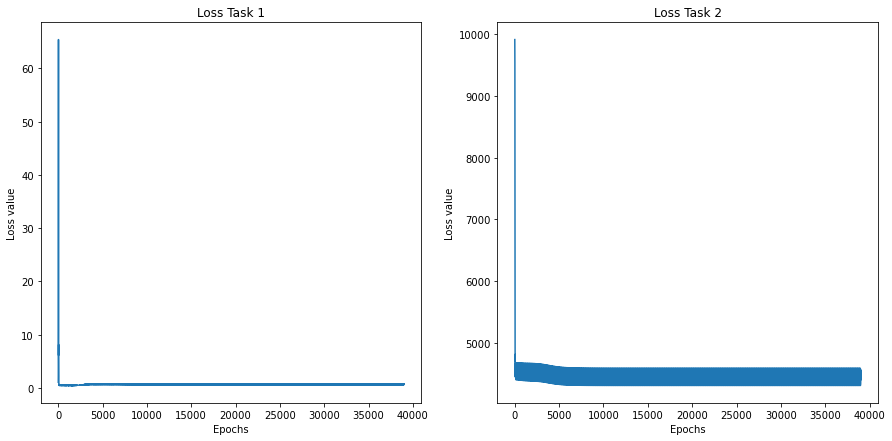

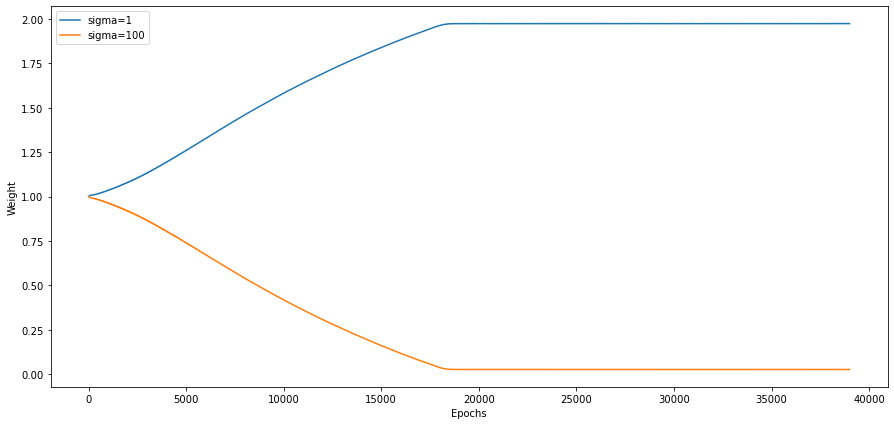

In [21]:
losses = [Ls[0], Ls[1]]
titles = ['Loss Task 1', 'Loss Task 2']
xlabels = 'Epochs'
ylabels_l = 'Loss value'
ylabels_w = 'Weight'
legends = ['sigma=1', 'sigma=100']

fig_loss = plotArange(1, 2, losses, xlabels, ylabels_l, titles)
fig_w = multiplePlot(Ws, xlabels, ylabels_w, legends)

### Toy Example with 10 Tasks

In [4]:
from src.gradNorm import GradNorm
tf.compat.v1.reset_default_graph()


sigmas_10 = [48.0, 3.0, 54.0, 16.0, 9.0, 30.0, 52.0, 26.0, 47.0, 81.0]
B = np.random.normal(scale=10, size=(100, 250)).astype(np.float32)
epsilons_10 = np.random.normal(scale=3.5, size=(10, 100, 250)).astype(np.float32)
X_10, Y_10 = createData(B, epsilons_10, sigmas_10, T=10)
print('X_10 shape: ', X_10.shape)
print('Y_10 shape: ', Y_10.shape)
# losses_10 = [tf.keras.losses.MeanSquaredError() for i in range(10)]
losses = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()]
metrics = [tf.keras.metrics.Mean() for i in range(10)]
weights = [1.0 for i in range(10)]

tf.keras.backend.clear_session()
model=toyExample(Tasks=10)

lr_schedule_model = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=5000,
    decay_rate=0.2)
lr_schedule_ws = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=5000,
    decay_rate=0.2)

Ls_10, Ws_10 = GradNorm(model, X_10, Y_10, 10, weights, losses, metrics, LR=[lr_schedule_model, lr_schedule_ws], epochs=10, verbose=True)

X_10 shape:  (10000, 250)
Y_10 shape:  (10000, 10, 100)
Num GPUs Available:  2
Build in CUDA:  True
Epoch     0: -> Loss task 00: 1172.278, w00: 0.881370 Loss task 01: 13.656, w01: 1.333557 Loss task 02: 1509.174, w02: 0.756519 Loss task 03: 145.848, w03: 1.162994 Loss task 04: 52.860, w04: 1.142012 Loss task 05: 471.392, w05: 1.239273 Loss task 06: 1364.404, w06: 0.770629 Loss task 07: 367.480, w07: 1.184863 Loss task 08: 1149.230, w08: 0.868488 Loss task 09: 3308.008, w09: 0.660295 
Epoch     1: -> Loss task 00: 1141.320, w00: 0.766927 Loss task 01: 9.142, w01: 1.483494 Loss task 02: 1471.774, w02: 0.635354 Loss task 03: 136.396, w03: 1.344632 Loss task 04: 45.289, w04: 1.290605 Loss task 05: 456.388, w05: 1.257577 Loss task 06: 1327.665, w06: 0.662216 Loss task 07: 354.149, w07: 1.317147 Loss task 08: 1117.580, w08: 0.762180 Loss task 09: 3209.682, w09: 0.479868 
Epoch     2: -> Loss task 00: 1130.714, w00: 0.638825 Loss task 01: 7.639, w01: 1.678689 Loss task 02: 1458.935, w02: 0.5

## SSB-VAE + GradNorm
### gamma = 100

In [5]:
from src.util import *
from src.gradNormSSBVAE import GradNormSSBVAE
from src.ssb_vae import SSBVAE

tf.compat.v1.reset_default_graph()

tf.keras.backend.clear_session()
tic = time.perf_counter()
n_classes, labels, labels_total, labels_test, X_total, X_test, X_total_input, X_test_input, Y_total_input = load_data(0.9,addval=1,reseed=0,seed_to_reseed=79)
vae,encoder,generator, losses = SSBVAE(X_total.shape[1],n_classes,Nb=int(16),units=500,layers_e=2,
                                       layers_d=0,beta=10000000.0 ,alpha=10000.0,lambda_=0.015625)
plot_model(vae, show_shapes=True)

# vae.fit(X_total_input, [X_total, Y_total_input], epochs=10 , batch_size=batch_size,verbose=1)
r = GradNormSSBVAE(vae, X_total_input, [X_total, Y_total_input], [1.0,1.0], 
               verbose=True, epochs=20, gradNorm=True, alpha=10.5, gamma=100.0, LR=1e-3, batch_size=512)

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               256500    
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
last_shared_layer (Dense)    (None, 500)               250500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
Total params: 761,500
Trainable params: 759,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
____________________________________________

In [6]:
total_hash, test_hash = hash_data(encoder,X_total_input,X_test_input)
p100_b,r100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK")
map100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK",eval_tipo="MAP",K=100)
print("p100_b: ", p100_b)
print("r100_b: ", r100_b)
print("map100_b: ", map100_b)


p100_b:  0.14065263157894853
r100_b:  0.0024371166266274505
map100_b:  0.16914517189685058


### gamma = 1000

In [7]:
vae,encoder,generator, losses = SSBVAE(X_total.shape[1],n_classes,Nb=int(16),units=500,layers_e=2,
                                       layers_d=0,beta=10000000.0 ,alpha=10000.0,lambda_=0.015625)
plot_model(vae, show_shapes=True)

# vae.fit(X_total_input, [X_total, Y_total_input], epochs=10 , batch_size=batch_size,verbose=1)
r = GradNormSSBVAE(vae, X_total_input, [X_total, Y_total_input], [1.0,1.0], 
               verbose=True, epochs=20, gradNorm=True, alpha=10.5, gamma=1000.0, LR=1e-3, batch_size=512)

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
last_shared_layer (Dense)    (None, 500)               250500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
Total params: 761,500
Trainable params: 759,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
____________________________________________

In [8]:
total_hash, test_hash = hash_data(encoder,X_total_input,X_test_input)
p100_b,r100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK")
map100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK",eval_tipo="MAP",K=100)
print("p100_b: ", p100_b)
print("r100_b: ", r100_b)
print("map100_b: ", map100_b)

p100_b:  0.38181578947368217
r100_b:  0.006642134058718508
map100_b:  0.4133959066712247


### gamma = 100.000.000.000

In [9]:
vae,encoder,generator, losses = SSBVAE(X_total.shape[1],n_classes,Nb=int(16),units=500,layers_e=2,
                                       layers_d=0,beta=10000000.0 ,alpha=10000.0,lambda_=0.015625)
plot_model(vae, show_shapes=True)

# vae.fit(X_total_input, [X_total, Y_total_input], epochs=10 , batch_size=batch_size,verbose=1)
r = GradNormSSBVAE(vae, X_total_input, [X_total, Y_total_input], [1.0,1.0], 
               verbose=True, epochs=20, gradNorm=True, alpha=10.5, gamma=100000000000.0, LR=1e-3, batch_size=512)

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
last_shared_layer (Dense)    (None, 500)               250500    
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
Total params: 761,500
Trainable params: 759,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
____________________________________________

In [10]:
total_hash, test_hash = hash_data(encoder,X_total_input,X_test_input)
p100_b,r100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK")
map100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK",eval_tipo="MAP",K=100)
print("p100_b: ", p100_b)
print("r100_b: ", r100_b)
print("map100_b: ", map100_b)

p100_b:  0.8871526315789492
r100_b:  0.015397984852573439
map100_b:  0.8925453403239365


### gamma = 1.000.000.000

In [11]:
vae,encoder,generator, losses = SSBVAE(X_total.shape[1],n_classes,Nb=int(16),units=500,layers_e=2,
                                       layers_d=0,beta=10000000.0 ,alpha=10000.0,lambda_=0.015625)
plot_model(vae, show_shapes=True)

# vae.fit(X_total_input, [X_total, Y_total_input], epochs=10 , batch_size=batch_size,verbose=1)
r = GradNormSSBVAE(vae, X_total_input, [X_total, Y_total_input], [1.0,1.0], 
               verbose=True, epochs=20, gradNorm=True, alpha=10.5, gamma=1000000000.0, LR=1e-3, batch_size=512)

pre-encoder network:
Model: "pre-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_6 (Batch (None, 500)               2000      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
last_shared_layer (Dense)    (None, 500)               250500    
_________________________________________________________________
batch_normalization_7 (Batch (None, 500)               2000      
Total params: 761,500
Trainable params: 759,500
Non-trainable params: 2,000
_________________________________________________________________
generator network:
Model: "generator/decoder"
____________________________________________

In [12]:
total_hash, test_hash = hash_data(encoder,X_total_input,X_test_input)
p100_b,r100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK")
map100_b = evaluate_hashing_DE(labels,total_hash, test_hash,labels_total,labels_test,tipo="topK",eval_tipo="MAP",K=100)
print("p100_b: ", p100_b)
print("r100_b: ", r100_b)
print("map100_b: ", map100_b)

p100_b:  0.891289473684212
r100_b:  0.015469336953505984
map100_b:  0.8940766953000178
